In [1]:
import cv2
from PIL import Image, ImageDraw
import numpy as np
import torch
import torch.nn as nn
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Detect faces on an input image

In [2]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# but we try to run on CPU
device = torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [3]:
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn

    """
    def _draw(self, frame, boxes):
        for box in boxes:
            # Draw rectangle on frame
            cv2.rectangle(frame,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 0, 255),
                          thickness=2)


        return frame
    """

    def process_image(self, image_path):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """
        #img = cv2.imread(image_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = Image.open(image_path)

        # detect face box, probability and landmarks
        boxes, _ = self.mtcnn.detect(img, landmarks=False)
        # draw on frame
        #img = self._draw(img, boxes)
        return img, boxes

In [4]:
#help(MTCNN)

In [5]:
mtcnn = MTCNN(keep_all=True, device=device)
fcd = FaceDetector(mtcnn)

In [6]:
img, boxes = fcd.process_image('dls2020-final-project-autoencoders/example_images/hp1.jpg')
print(boxes)

[[373.57483   41.983856 447.23444  129.00287 ]
 [131.59392  146.92427  192.64299  227.17256 ]]


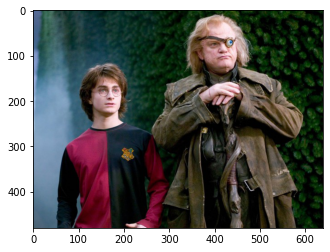

In [7]:
plt.imshow(img)

In [8]:
type(img), img.size

(PIL.JpegImagePlugin.JpegImageFile, (640, 480))

# Load AE, smile vector

In [9]:
dim_code = 512
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1. Encoder
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.enc_pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 48 -> 24
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 24 -> 12
        
        self.enc_fc0 = nn.Linear(64*12*12, dim_code)
        
        # 2. Decoder
        self.dec_fc0 = nn.Linear(dim_code, 64*12*12)
        
        self.dec_upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2) # 12 -> 24
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.dec_upsample1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # 24 -> 48
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(3),
            nn.Sigmoid())

    def decoder_forward(self, latent_code):
        x = self.dec_fc0(latent_code)
        x = x.view(-1, 64, 12, 12)
        x = self.dec_conv0(self.dec_upsample0(x))
        reconstruction = self.dec_conv1(self.dec_upsample1(x))
        return reconstruction

    def forward(self, x):
        # 1. Encoder
        x = self.enc_pool0(self.enc_conv0(x))
        x = self.enc_pool1(self.enc_conv1(x))
        x = torch.flatten(x, 1)
        
        # 2. Latent code
        latent_code = self.enc_fc0(x)
        
        # 3. Decoder
        reconstruction = self.decoder_forward(latent_code)
        
        return reconstruction, latent_code

In [10]:
rescale_size = (48, 48)
data_transforms = transforms.Compose([
        transforms.Resize(rescale_size), # but here all images are the same size, so don't use Resize()
        transforms.ToTensor()
        #transforms.Normalize(train_data_mean, train_data_std)
    ])

def image2tensor(img_data):
    # img_data -- numpy.ndarray, its shape: HxWxC
    # but we use transforms.ToTensor() which is able to work with HxWxC properly (see documentation)
    img_data_tensor = data_transforms(img_data)
    return img_data_tensor


def tensor2image(img_data_tensor):
    image = img_data_tensor.detach().cpu()
    image = image.numpy() # (CxHxW)
    image = np.moveaxis(image, 0, 2) # (HxWxC)
    return image

In [11]:
class SmileAutoencoder:
    def __init__(self, ae_model_path, smile_vector_path):
        self.autoencoder = Autoencoder()
        self.autoencoder.load_state_dict(torch.load(ae_model_path))
        self.autoencoder.eval()
        self.autoencoder = self.autoencoder.to(device)
        self.smile_vector = torch.load(smile_vector_path).to(device)
    
    def add_smile(self, img):
        img_tensor = image2tensor(img).unsqueeze(0).to(device, torch.float32)
        self.autoencoder.eval()
        with torch.no_grad():
            _, latent_vector = self.autoencoder.forward(img_tensor)
            latent_vector = latent_vector + self.smile_vector

            output = self.autoencoder.decoder_forward(latent_vector)
            output = output.squeeze(0)
        return output

In [12]:
smile_ae = SmileAutoencoder('./vanilla_ae.pth', './smile_ae_vector.pt')

# Add smile for detected faces

In [13]:
boxes

array([[373.57483 ,  41.983856, 447.23444 , 129.00287 ],
       [131.59392 , 146.92427 , 192.64299 , 227.17256 ]], dtype=float32)

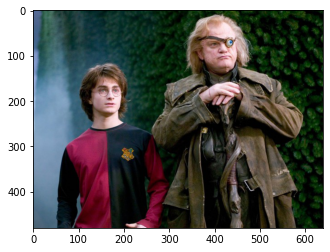

In [14]:
plt.imshow(img)

61 81
torch.Size([3, 48, 48])


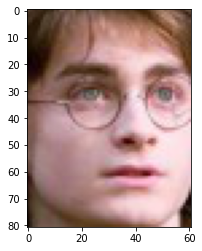

In [41]:
#for box in boxes:
box = boxes[1]
top_x, top_y = int(box[0]), int(box[1])
bot_x, bot_y = int(box[2]), int(box[3])
#face_img = img[top_y:bot_y, top_x:bot_x] # for opencv
face_cropped_part = img.crop([top_x, top_y, bot_x, bot_y])
w, h = face_cropped_part.size
print(w, h)

output = smile_ae.add_smile(face_cropped_part)
print(output.shape)
plt.imshow(face_cropped_part)

In [24]:
type(output)

torch.Tensor

In [25]:
output = tensor2image(output)

In [29]:
output.shape

(48, 48, 3)

In [37]:
im = Image.fromarray(np.uint8(output*255))
im = im.resize((w, h))

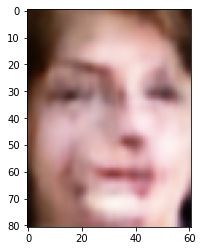

In [38]:
plt.imshow(im)

In [40]:
im.size

(61, 81)

Ужас :(